In [28]:
""" Inspired by example from
https://github.com/Vict0rSch/deep_learning/tree/master/keras/recurrent
Uses the TensorFlow backend
The basic idea is to detect anomalies in a time-series.
"""
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from numpy import arange, sin, pi, random


In [29]:
import csv

In [30]:
np.random.seed(1234)

# Global hyper-parameters
sequence_length = 10
epochs = 5
batch_size = 50


In [41]:
def readCSV():
    f = open('/home/mani/train.csv')
    states = []
    try:
        reader = csv.reader(f)
        for row in reader:
            states.append(row)
    finally:
        f.close()
    train_data = np.array(states)
    print (train_data.shape)
    return train_data

In [42]:
# readCSV()

In [43]:
def z_norm(result):
    result = np.float64(result)
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean




In [44]:
def get_split_prep_data(train_start, train_end,
                        test_start, test_end):
    #data = gen_wave()
    data = readCSV()
    print("Length of Data", len(data))

    # train data
    print("Creating train data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)

    result, result_mean = z_norm(result)

    print ("Mean of train data : ", result_mean)
    print ("Train data shape  : ", result.shape)
    #print result
    train = result[train_start:train_end, :]
    #np.random.shuffle(train)  # shuffles in-place
    X_train = train[:, :-1]
    y_train = train[:, -1]
    #X_train, y_train = dropin(X_train, y_train)

    print("Shape X_train", np.shape(X_train))
    print("Shape y_train", np.shape(y_train))

    # test data
    print ("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = z_norm(result)

    print ("Mean of test data : ", result_mean)
    print ("Test data shape  : ", result.shape)

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_test", np.shape(X_test))
    print("Shape y_test", np.shape(y_test))


    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test

In [45]:
#get_split_prep_data(0,600,601,675)

In [46]:
def build_model():
    model = Sequential()
    layers = {'input': 1, 'hidden1': 5, 'hidden2': 10, 'hidden3': 5, 'output': 1}

    model.add(LSTM(
            input_length=sequence_length - 1,
            input_dim=layers['input'],
            output_dim=layers['hidden1'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden2'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden3'],
            return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
            output_dim=layers['output']))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model

In [51]:
def run_network(model=None, data=None):
    global_start_time = time.time()

    if data is None:
        print ('Loading data... ')
        # train on first 700 samples and test on next 300 samples (has anomaly)
        X_train, y_train, X_test, y_test = get_split_prep_data(0, 80000, 80001, 82000)
    else:
        X_train, y_train, X_test, y_test = data

    print ('\nData Loaded. Compiling...\n')

    
    if model is None:
        model = build_model()

    try:
        print("Training...")
        model.fit(
                X_train, y_train,
                batch_size=batch_size, nb_epoch=epochs, validation_split=0.05)
        print("Predicting...")
        predicted = model.predict(X_test)
        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("prediction exception")
        print ('Training duration (s) : ', time.time() - global_start_time)
        return model, y_test, 0

    print( 'Training duration (s) : ', time.time() - global_start_time)

    return model, y_test, predicted


In [52]:
def showPlot(Predicted, y_test):
    try:
        plt.figure(1)
        plt.subplot(311)
        plt.title("Actual Test Signal w/Anomalies")
        plt.plot(y_test[:len(y_test)], 'b')
        plt.subplot(312)
        plt.title("Predicted Signal")
        plt.plot(predicted[:len(y_test)], 'g')
        plt.subplot(313)
        plt.title("Squared Error")
        y_te = np.array(y_test,dtype=float)
        pred = np.array(predicted,dtype=float)

        mse = ((y_te - pred) ** 2)
        plt.plot(mse, 'r')
        plt.show()
        print("success")
        plt.savefig( 'myfig.png' )
    except Exception as e:
        print("plotting exception")
        print (str(e))

In [53]:
model,y_test,predicted=run_network()

Loading data... 
(82128, 1)
Length of Data 82128
Creating train data...
Mean of train data :  1.45791223903
Train data shape  :  (79990, 10, 1)
Shape X_train (79990, 9, 1)
Shape y_train (79990, 1)
Creating test data...
Mean of test data :  1.47642031171
Test data shape  :  (1989, 10, 1)
Shape X_test (1989, 9, 1)
Shape y_test (1989, 1)

Data Loaded. Compiling...

Compilation Time :  0.02780461311340332
Training...
Train on 75990 samples, validate on 4000 samples
Epoch 1/5
75990/75990 [==============================] - 114s - loss: 0.9531 - val_loss: 0.9243
Epoch 2/5
75990/75990 [==============================] - 106s - loss: 0.8939 - val_loss: 0.9070
Epoch 3/5
75990/75990 [==============================] - 95s - loss: 0.8836 - val_loss: 0.9008
Epoch 4/5
75990/75990 [==============================] - 103s - loss: 0.8756 - val_loss: 0.9013
Epoch 5/5
75990/75990 [==============================] - 91s - loss: 0.8700 - val_loss: 0.8961
Predicting...
Reshaping predicted
Training duration (s) 

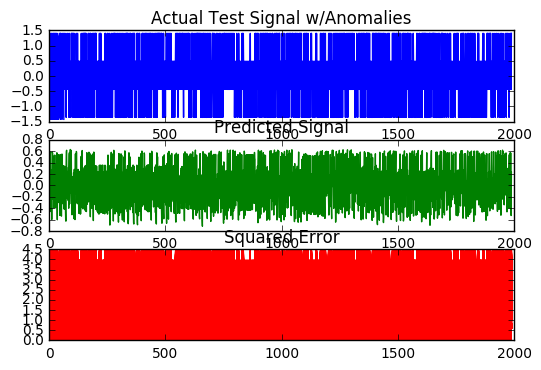

success


In [54]:
showPlot(predicted,y_test)